# Reinforcement Learning training - Young Mavericks 17/05/2019

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import gym
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

%matplotlib inline

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

## Relevant resources and documentation
Most topics we discuss in this training come from the book by Sutton and Barto [1]. Both researchers have been involved in the field of RL for many years, and they compiled the book as a complete introduction. It has become a standard textbook in most RL courses from universities across the world.

Additionally, we're using the following packages:
 - [OpenAI gym](https://github.com/openai/gym)
 - [numpy](https://docs.scipy.org/doc/numpy/reference/)


[1] Sutton and Barto 2018 - Reinforcement Learning: An Introduction http://incompleteideas.net/book/the-book-2nd.html

## The OpenAI gym environment
We'll use an example environment also found in Sutton & Barto's book: the grid world. Since `gym` is the de-facto standard package for RL environment, let's familiarize ourselves with its inner workings. Don't forget to check the documentation for relevant functions, attributes and classes.

In [2]:
from gridworld import GridworldEnv

# Don't change to WindyGridworldEnv unless you know what you're doing!
from windy_gridworld import WindyGridworldEnv

env = GridworldEnv() # Loads the grid world

> Your turn: reset the environment and draw it.

In [3]:
obs = env.reset()
env.render()

T  o  o  o
o  o  o  o
o  o  o  o
o  o  x  T


> Your turn: find out the following information: how many actions are there? How many states are there?  

In [4]:
print(f"number of actions: {env.nA}")
print(f"number of states: {env.nS}")

number of actions: 4
number of states: 16


> Your turn: let an agent take a sequence of 10 random actions in the world and print observations. What does the format represent?

In [5]:
obs = env.reset()
for i in range(10):
    X = env.step(env.action_space.sample())
    env.render()
    print(f"-- {X} --")

T  o  o  o
o  o  x  o
o  o  o  o
o  o  o  T
-- (6, -1.0, False, {'prob': 1.0}) --
T  o  x  o
o  o  o  o
o  o  o  o
o  o  o  T
-- (2, -1.0, False, {'prob': 1.0}) --
T  o  o  x
o  o  o  o
o  o  o  o
o  o  o  T
-- (3, -1.0, False, {'prob': 1.0}) --
T  o  o  o
o  o  o  x
o  o  o  o
o  o  o  T
-- (7, -1.0, False, {'prob': 1.0}) --
T  o  o  x
o  o  o  o
o  o  o  o
o  o  o  T
-- (3, -1.0, False, {'prob': 1.0}) --
T  o  o  o
o  o  o  x
o  o  o  o
o  o  o  T
-- (7, -1.0, False, {'prob': 1.0}) --
T  o  o  x
o  o  o  o
o  o  o  o
o  o  o  T
-- (3, -1.0, False, {'prob': 1.0}) --
T  o  o  x
o  o  o  o
o  o  o  o
o  o  o  T
-- (3, -1.0, False, {'prob': 1.0}) --
T  o  o  o
o  o  o  x
o  o  o  o
o  o  o  T
-- (7, -1.0, False, {'prob': 1.0}) --
T  o  o  o
o  o  x  o
o  o  o  o
o  o  o  T
-- (6, -1.0, False, {'prob': 1.0}) --


> Your turn: Take some time to figure out what the environment's dynamics are and where they are stored. Figure out what the format represents and try to relate it to what was explained in the slides. Note that this is a deterministic environment. What would a stochastic environment look like?

In [6]:
env.P
# env.P represents the transition probabilities of the environment.
# env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
# env.nS is a number of states in the environment. 
# env.nA is a number of actions in the environment.

{0: {0: [(1.0, 0, 0.0, True)],
  1: [(1.0, 0, 0.0, True)],
  2: [(1.0, 0, 0.0, True)],
  3: [(1.0, 0, 0.0, True)]},
 1: {0: [(1.0, 1, -1.0, False)],
  1: [(1.0, 2, -1.0, False)],
  2: [(1.0, 5, -1.0, False)],
  3: [(1.0, 0, -1.0, True)]},
 2: {0: [(1.0, 2, -1.0, False)],
  1: [(1.0, 3, -1.0, False)],
  2: [(1.0, 6, -1.0, False)],
  3: [(1.0, 1, -1.0, False)]},
 3: {0: [(1.0, 3, -1.0, False)],
  1: [(1.0, 3, -1.0, False)],
  2: [(1.0, 7, -1.0, False)],
  3: [(1.0, 2, -1.0, False)]},
 4: {0: [(1.0, 0, -1.0, True)],
  1: [(1.0, 5, -1.0, False)],
  2: [(1.0, 8, -1.0, False)],
  3: [(1.0, 4, -1.0, False)]},
 5: {0: [(1.0, 1, -1.0, False)],
  1: [(1.0, 6, -1.0, False)],
  2: [(1.0, 9, -1.0, False)],
  3: [(1.0, 4, -1.0, False)]},
 6: {0: [(1.0, 2, -1.0, False)],
  1: [(1.0, 7, -1.0, False)],
  2: [(1.0, 10, -1.0, False)],
  3: [(1.0, 5, -1.0, False)]},
 7: {0: [(1.0, 3, -1.0, False)],
  1: [(1.0, 7, -1.0, False)],
  2: [(1.0, 11, -1.0, False)],
  3: [(1.0, 6, -1.0, False)]},
 8: {0: [(1.0, 4

## Policy Evaluation
As a first step, we're going to implement _policy evaluation_. This algorithm requires a policy $\pi(s)$, and in turn calculates the value function $V(s)$. Note that this is purely an evaluation: no improvements on the evluation are made (yet). As a start, we initialize $\pi(s)$ randomly.

In [7]:
def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Arguments:
        policy: [S, A] shaped matrix representing the policy.
        env: the OpenAI environment. 
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.nS)
    while True:
        delta = 0.0
        
        for state in range(env.nS):
            v = V[state]
            
            sum_a = 0
            for action, action_tuple in env.P[state].items():
                (prob, next_state, reward, done) = action_tuple[0]
                
                sum_a += policy[state][action] * prob * (reward + (discount_factor * V[next_state]))
            V[state] = sum_a
            
            delta = max(delta, np.abs(v - V[state]))
        
        if delta < theta:
            break
                
    return np.array(V)

In [8]:
# Let's run your code, does it make sense?
random_policy = np.ones([env.nS, env.nA]) / env.nA
V = policy_eval(random_policy, env)
V

array([  0.        , -13.99993529, -19.99990698, -21.99989761,
       -13.99993529, -17.9999206 , -19.99991379, -19.99991477,
       -19.99990698, -19.99991379, -17.99992725, -13.99994569,
       -21.99989761, -19.99991477, -13.99994569,   0.        ])

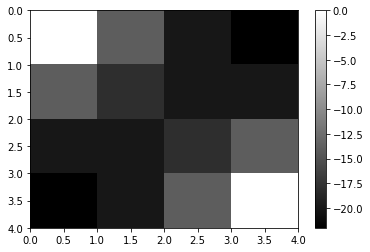

In [9]:
def plot_gridworld_value(V):
    plt.figure()
    c = plt.pcolormesh(V, cmap='gray')
    plt.colorbar(c)
    plt.gca().invert_yaxis()  # In the array, first row = 0 is on top

# Making a plot always helps
plot_gridworld_value(V.reshape(env.shape))

In [10]:
# Test whether your value function is in the correct shape!
v = policy_eval(random_policy, env)
assert v.shape == (env.nS)

In [11]:
# Test whether the values are approximately correct!
expected_v = np.array([0, -14, -20, -22, -14, -18, -20, -20, -20, -20, -18, -14, -22, -20, -14, 0])
assert np.allclose(v, expected_v, atol=1e-3)

## 2. Policy Iteration
Now, use the policy evaluation in combination with policy improvement to implement policy iteration.

Policy iteration will find a good policy for our environment, improving on the random policy we gave it in the beginning. 

In [12]:
def policy_improvement(env, discount_factor=0.9):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI envrionment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """
    # Start with a random policy
    policy = np.ones([env.nS, env.nA]) / env.nA
    while True:
        V = policy_eval(policy, env, discount_factor)
        
        policy_stable = True
        for state in range(env.nS):
            old_action = policy[state]
            
            action_values = []
            for action, action_tuple in env.P[state].items():
                (prob, next_state, reward, done) = action_tuple[0]
                
                action_values.append(prob * (reward + (discount_factor * V[next_state])))
            
            policy[state] = np.zeros(len(policy[state]))
            policy[state][np.argmax(action_values)] = 1
            
            if (old_action != policy[state]).any():
                policy_stable = False
        
        if policy_stable:
            V = policy_eval(policy, env, discount_factor)
            break
    
    return policy, V

Policy Probability Distribution:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 3]
 [0 0 3 2]
 [0 0 1 2]
 [0 1 1 0]]
^<<<
^^<v
^^>v
^>>^

Value Function:
[ 0.   -1.   -1.9  -2.71 -1.   -1.9  -2.71 -1.9  -1.9  -2.71 -1.9  -1.
 -2.71 -1.9  -1.    0.  ]

Reshaped Grid Value Function:
[[ 0.   -1.   -1.9  -2.71]
 [-1.   -1.9  -2.71 -1.9 ]
 [-1.9  -2.71 -1.9  -1.  ]
 [-2.71 -1.9  -1.    0.  ]]



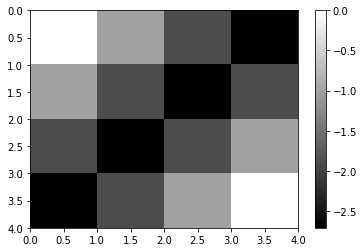

In [13]:
# Let's see what it does
policy, v = policy_improvement(env)
print("Policy Probability Distribution:")
print(policy)
print("")

def print_grid_policy(policy, symbols=["^", ">", "v", "<"]):
    symbols = np.array(symbols)
    for row in policy:
        print("".join(symbols[row]))

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print_grid_policy(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")

plot_gridworld_value(v.reshape(env.shape))

In [14]:
# Test the discount factor
policy_discount, v_discount = policy_improvement(env, discount_factor=0.9)
assert np.allclose(v_discount, np.array([
    0.0, -1.0, -1.9, -2.71, 
    -1.0, -1.9, -2.71, -1.9, 
    -1.9, -2.71, -1.9, -1.0, 
    -2.71, -1.9, -1.0, 0.0
]), atol=1e-3)

## Value Iteration
Next, implement the value iteration algorithm on the same environment.

In [15]:
def value_iteration(env, theta=0.0001, discount_factor=1.0):
    """
    Value Iteration Algorithm.
    
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.        
    """
    

    V = np.zeros(env.nS)
    policy = np.zeros([env.nS, env.nA])
    
    while True:
        delta = 0
        for state in range(len(V)):
            v = V[state]
            
            action_values = []
            for action, action_tuple in env.P[state].items():
                (prob, next_state, reward, done) = action_tuple[0]
                action_values.append(prob * (reward + discount_factor * V[next_state]))

            V[state] = max(action_values)
            
            policy[state] = np.zeros(env.nA)
            policy[state][np.argmax(action_values)] = 1
            
            delta = max(delta, np.abs(v - V[state]))
        
        if delta < theta:
            break
    
    return policy, V

In [16]:
# Oh let's test again
# Let's see what it does
policy, v = value_iteration(env)
print("Policy Probability Distribution:")
print(policy)
print("")

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print_grid_policy(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")

orig_policy_eval = policy_eval
del policy_eval
try:
    
    policy, v = value_iteration(env)
    assert np.allclose(v, np.array([0, -1, -2, -3, -1, -2, -3, -2, -2, -3, -2, -1, -3, -2, -1, 0]), atol=1e-3)
    # With this one it should be easy to get discount right as they do not pass it
    policy_discount, v_discount = value_iteration(env, discount_factor=0.9)
    assert np.allclose(v_discount, np.array([
        0.0, -1.0, -1.9, -2.71, 
        -1.0, -1.9, -2.71, -1.9, 
        -1.9, -2.71, -1.9, -1.0, 
        -2.71, -1.9, -1.0, 0.0
    ]), atol=1e-3)

finally:
    policy_eval = orig_policy_eval

Policy Probability Distribution:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]
^<<v
^^^v
^^>v
^>>^

Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



## Comparison
Now, try to compare the two training methods with a random baseline. This means we can play around a bit with the settings of the environment as well, and see where the trade-off (if there is one) is between the two. 

Take the following approach:
    1. Define a metric to evaluate how good a policy is on a level (i.e. how long it takes to complete a level, total reward)
    2. Run the algorithm multiple times on the standard environment and measure the metric
    3. Check the difference in performance.
    
Additionally, try to answer the following questions:
 - What happens if you terminate training of either policy or value iteration before convergence. How good are the trained policies? To they scale linearly in metric performance during training?
 - What happens if you increase the size of the environment? Can you make an estimation for how long it takes for algorithms to converge?
 - How would you speed up on the (naive) implementation?
 - Can you guess where neural networks are being used in state of the art models?
 - Can you adjust the GridWorldEnv environment itself in other ways? For instance, see what happens more terminal states are added, or removed?
 - What happens if we turn around the reward system: instead of giving -1 for every step you failed to reach a terminal state, you know achieve a +1 upon succesful completion.
 
 ### Try a different environment
 Thanks to the usage of `gym`, we can easily switch between different environments. In the code, there is also a WindyGridWorldEnv, is your code general enough to train on this level without much rewriting? How is this environment different? What differences do you see in training?

In [17]:
def random_argmax(X):
    """
    Perform an argmax, but break ties randomly
    """
    return np.random.choice(np.flatnonzero(X == X.max()))
        
def try_policy(N, policy):
    """
    Args:
        N: how many times to run the simulation
        policy: policy to be tested
    """
    lens = []
    for _ in range(N):
        state = env.reset()
        done = False
        episode_length = 0
        while not done:
            a = random_argmax(policy[state])
            episode_length += 1
            state, reward, done, _ = env.step(a)
        lens.append(episode_length)
    return sum(lens) / N

In [18]:
# Let's try it!
N = 20
random_policy = np.ones([env.nS, env.nA]) / env.nA
mean_random = try_policy(N, random_policy)
mean_v_policy =  try_policy(N, policy) # policy is one you defined earlier!

print(f"Mean episode length of random policy: {mean_random}")
print(f"Mean episode length of learned policy: {mean_v_policy}")

Mean episode length of random policy: 13.95
Mean episode length of learned policy: 1.9
